## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 2, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [ ]:
from astrid_GAN import AstridGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = AstridGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

# Online training during the test period
# Assume test_returns_df contains daily returns for the test period
for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.


Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...


In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

In [ ]:
asset_names = list(returns_df.columns)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.
    portfolio = SimpleGANPortfolio(gan_samples, weights)
    _, scr = portfolio.calculate_distribution_and_scr()
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = -532602.1923191344
Date 2020-01-02 00:00:00: SCR = -959375.4602937398
Date 2020-01-03 00:00:00: SCR = -1096007.8970597321
Date 2020-01-06 00:00:00: SCR = -1239813.6149920681
Date 2020-01-07 00:00:00: SCR = -495069.1428719465
Date 2020-01-08 00:00:00: SCR = -577741.5529800277
Date 2020-01-09 00:00:00: SCR = -662619.3830498231
Date 2020-01-10 00:00:00: SCR = -562042.2814069776
Date 2020-01-13 00:00:00: SCR = -624517.8857763454
Date 2020-01-14 00:00:00: SCR = -613336.0340380096
Date 2020-01-15 00:00:00: SCR = -632554.8430350793
Date 2020-01-16 00:00:00: SCR = -685353.8416338863
Date 2020-01-17 00:00:00: SCR = -801323.2959526086
Date 2020-01-20 00:00:00: SCR = -847206.0549174115
Date 2020-01-21 00:00:00: SCR = -531081.988401481
Date 2020-01-22 00:00:00: SCR = -498088.51091757347
Date 2020-01-23 00:00:00: SCR = -505557.5140313693
Date 2020-01-24 00:00:00: SCR = -546106.2229462486
Date 2020-01-27 00:00:00: SCR = -574800.5479319273
Date 2020-01-28 00:00:00: SCR

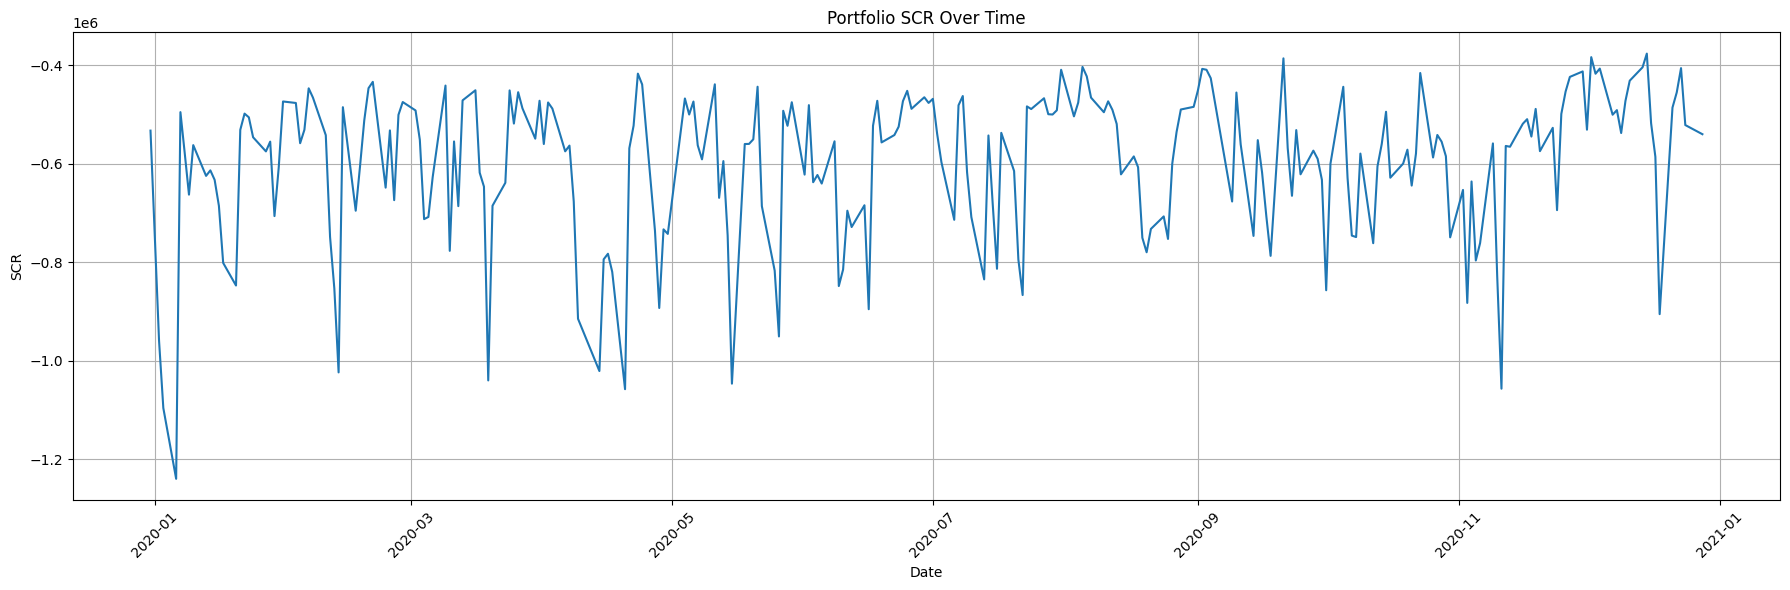

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
test_start_date = test_returns_df.index.min()
print(test_start_date)

cutoff_date = test_start_date - pd.Timedelta(days=252)

historical_df = entire_df.loc[cutoff_date:]

historical_df.head()

2020-01-02 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-04-25,-0.006224,0.004103,0.003786,-0.000216,-0.001686,-0.001023,-0.000010
2019-04-26,-0.003176,0.004320,0.002331,0.001602,0.002622,0.000301,-0.000010
2019-04-29,-0.000818,0.004778,0.000658,-0.001038,-0.000296,0.000885,-0.000031
2019-04-30,-0.003589,-0.005772,-0.002166,0.001101,0.000217,0.000636,-0.000010
2019-05-02,0.007208,0.000127,-0.005755,-0.001741,0.000427,-0.000861,-0.000010


In [ ]:
# CALCULATE DELTA BOF ARRAY
#entire_df = historical_df

eonia = entire_df.iloc[:, -1]

portfolio_returns = (entire_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

bof_0 = assets_0 - liabilities_0

delta_bof = bof - bof_0 # Delta BOF

daily_delta_bof = bof.diff().fillna(0)

delta_bof = daily_delta_bof


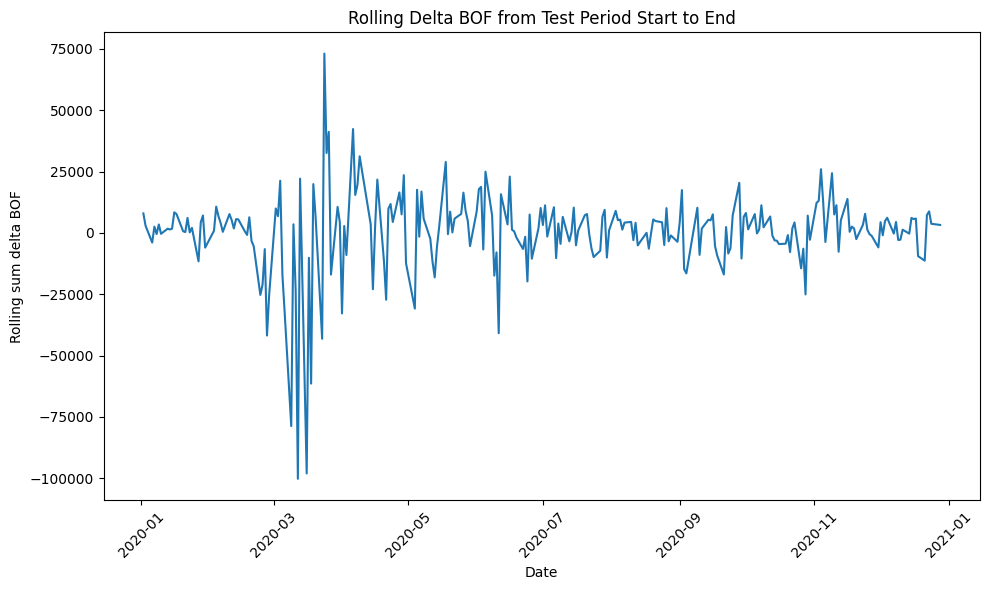

In [ ]:
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
test_delta_bof = delta_bof.loc[test_start_date:test_end_date]
plt.figure(figsize=(10, 6))
plt.plot(test_delta_bof.index, test_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

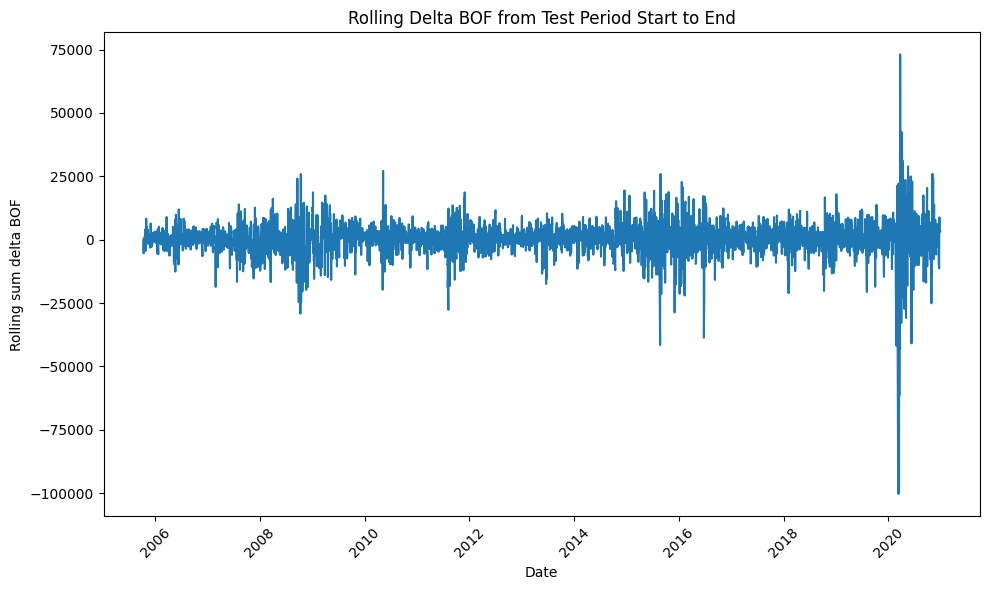

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(delta_bof.index, delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

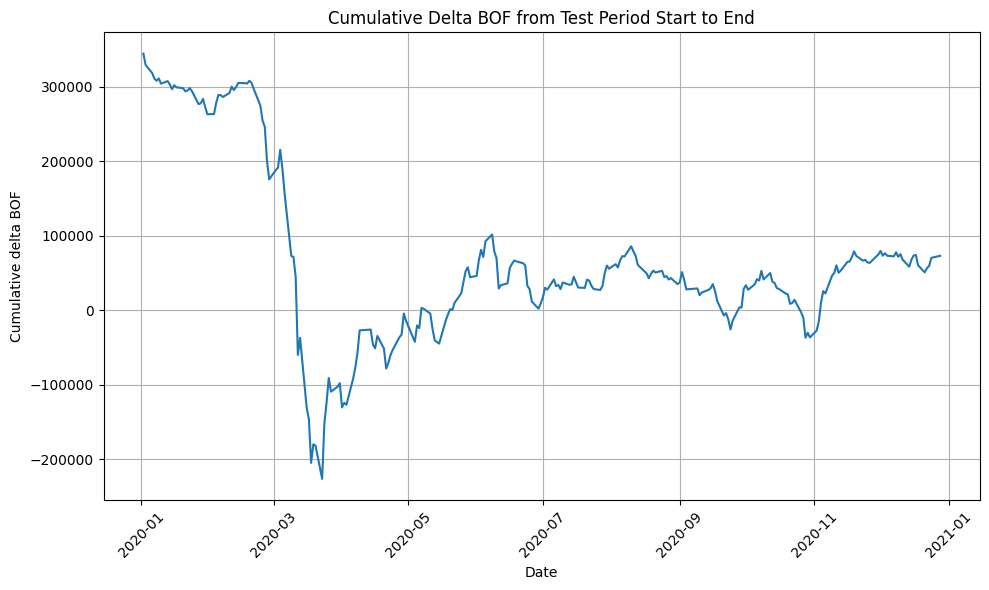

In [ ]:
# Suppose delta_bof is a pandas Series with a datetime index:
# For example:
# delta_bof = pd.Series(data_array, index=date_index)

# 1. Transform the daily delta_bof to a rolling 252-day basis.
#    Here, we compute the rolling sum over 252 days.
rolling_delta_bof = delta_bof.rolling(window=252).sum()

# 2. Determine the test period.
# Assume that returns_df contains historical data and test_returns_df contains the test period.
# Let test_start be the first date in test_returns_df.
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
rolling_test = rolling_delta_bof.loc[test_start_date:test_end_date]

# Option B: If you instead want to calculate the cumulative delta_bof (running sum)
# over the test period (starting at test_start), do this:
delta_bof_test = delta_bof.loc[test_start_date:test_end_date]
cumulative_delta_bof_test = delta_bof_test.cumsum()

# 3. Plot the cumulative delta_bof over the test period.
plt.figure(figsize=(10, 6))
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative delta BOF")
plt.title("Cumulative Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

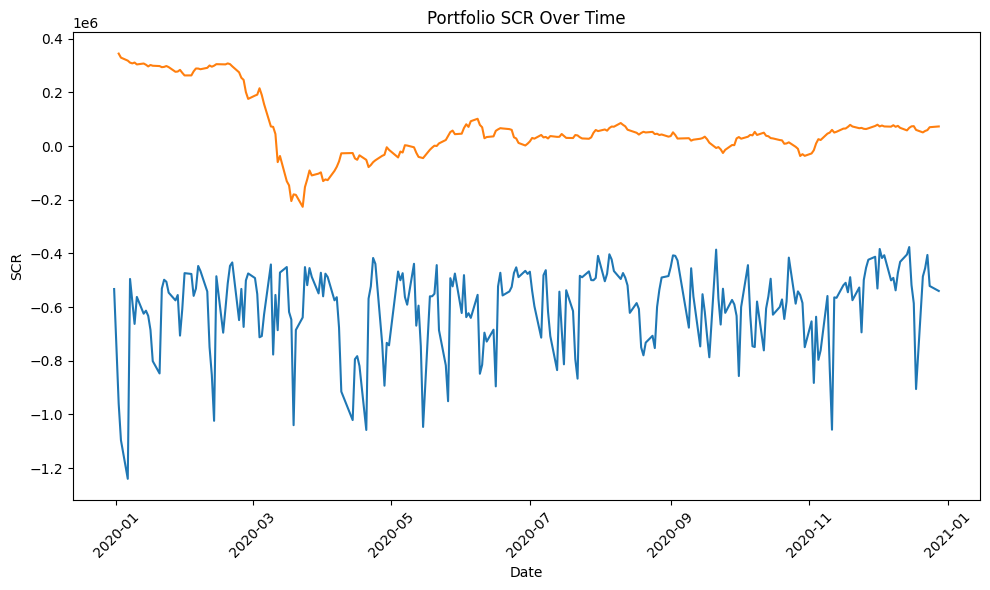

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Scaled = False


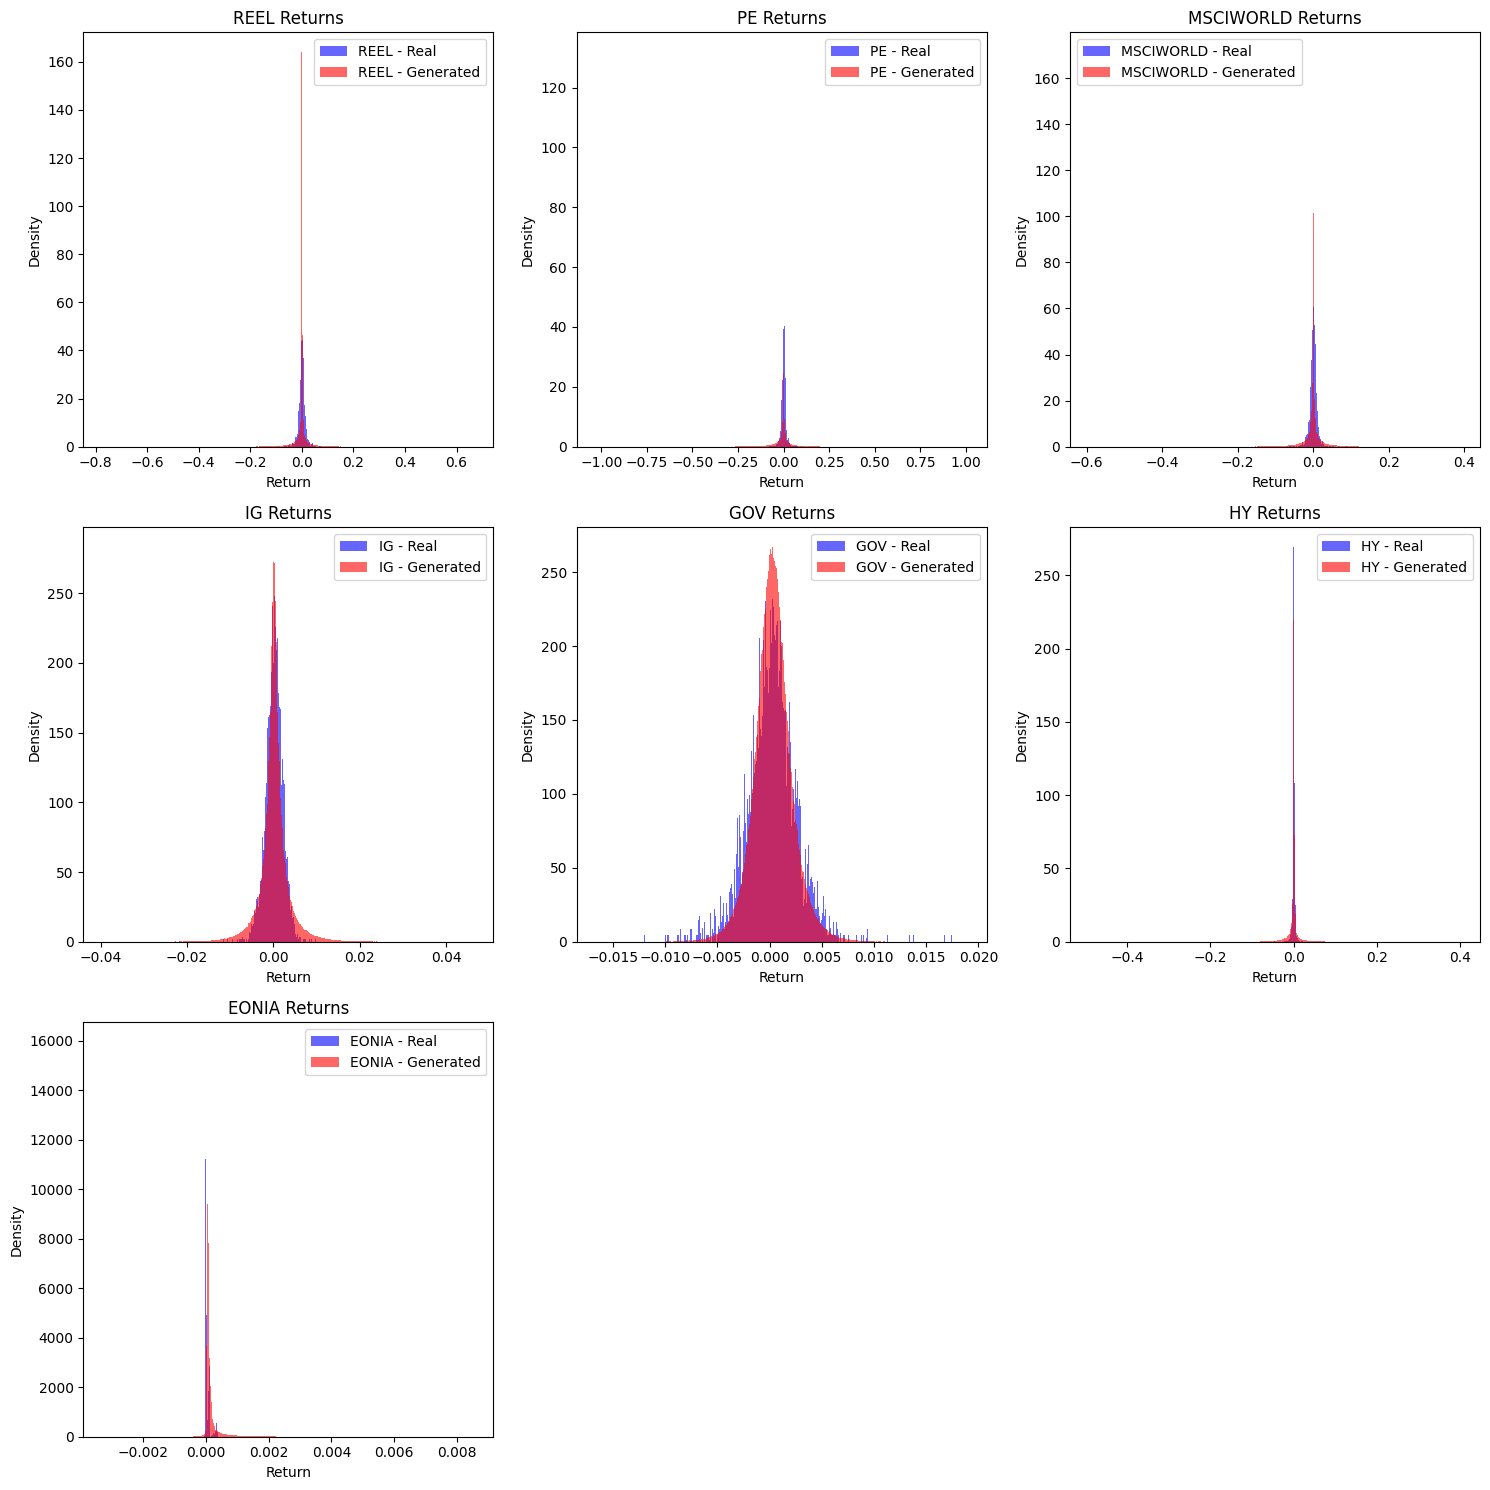


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.002099 0.036759 -1.557476 35.603909  -0.191278
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.004263 0.060810 -0.965240 33.978657  -0.315303
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.001961 0.029637 -2.225345 29.661091  -0.160483
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated  0.000233 0.003628  0.322329 10.317923  -0.013232
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000343 0.001895  0.144165  2.384513  -0.005427
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated -0.000802 0.016937 -1.021745 46.179745  -0.083883
         EONIA - Real  0.000032 0.

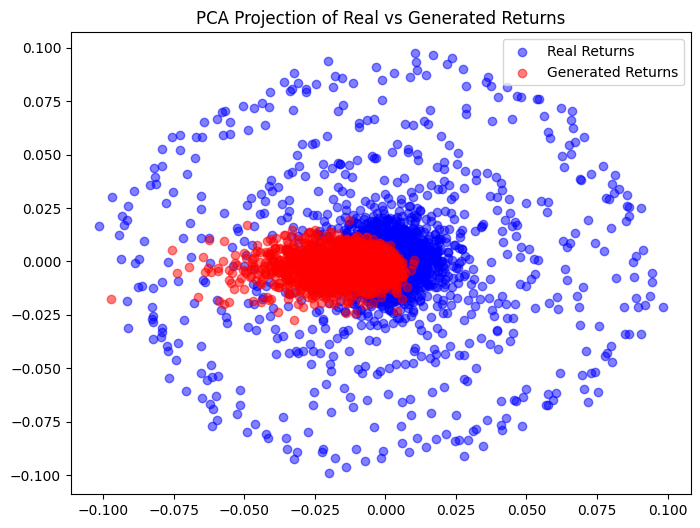

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


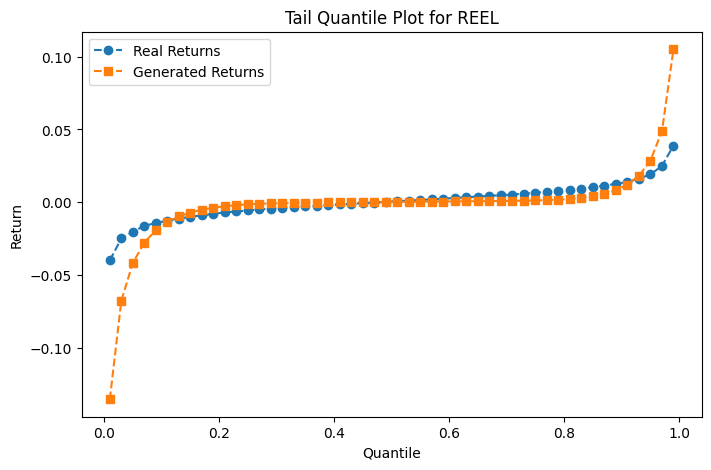


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 23.166039
Mean Distance: 0.010489
Median Distance: 0.000191
Standard Deviation: 0.183932


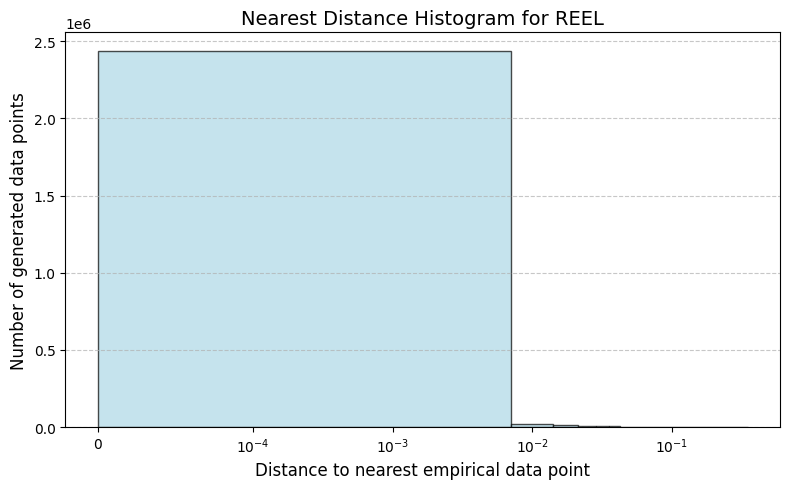


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.009549


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.003125
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.672550
✅ Generated samples are reasonably diverse


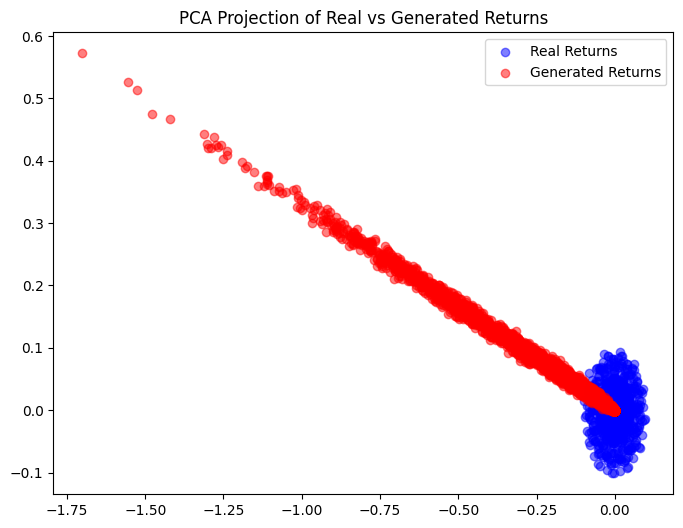

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt


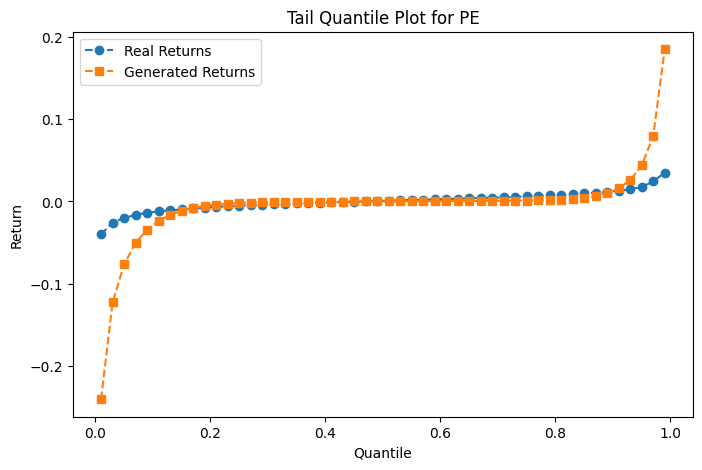


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 16.237109
Mean Distance: 0.010097
Median Distance: 0.000187
Standard Deviation: 0.176765


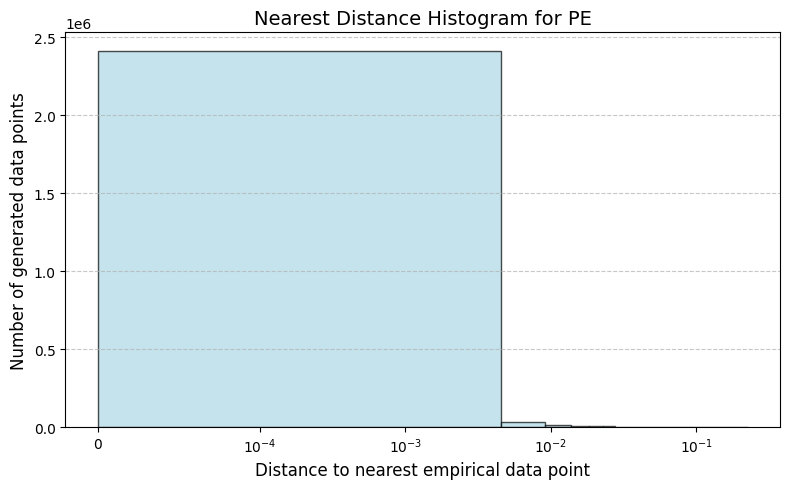


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.016812


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Variance of Real Data: 0.000098
Variance of Generated Data: 0.000680
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.352489
✅ Generated samples are reasonably diverse


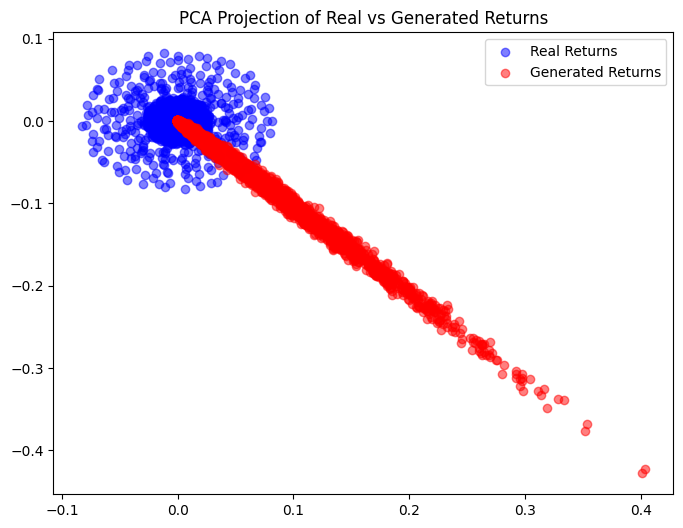

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt


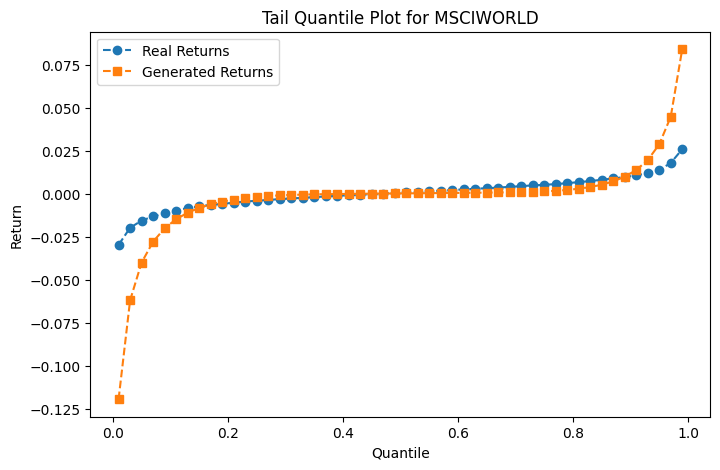


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt

📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 16.203303
Mean Distance: 0.007374
Median Distance: 0.000200
Standard Deviation: 0.143248


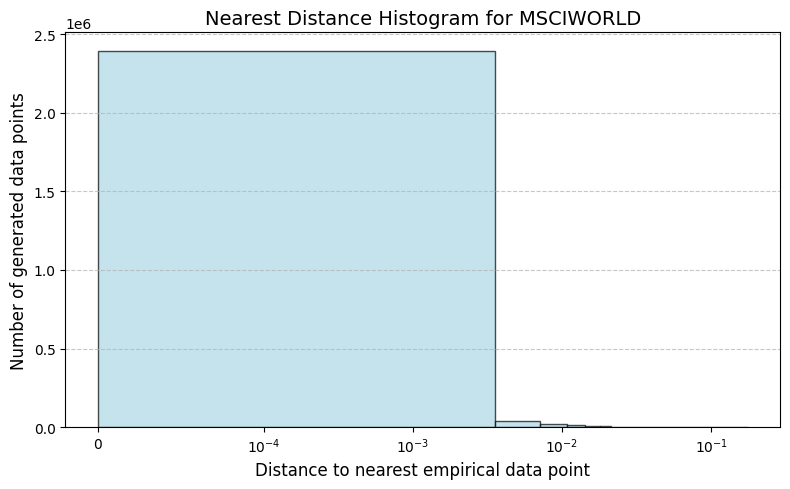


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
📊 Wasserstein Distance for MSCIWORLD: 0.007874


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000007
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.045581
✅ Generated samples are reasonably diverse


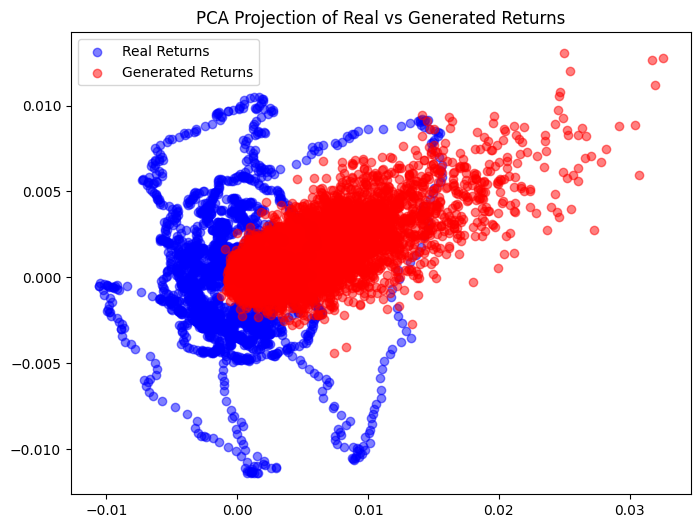

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt


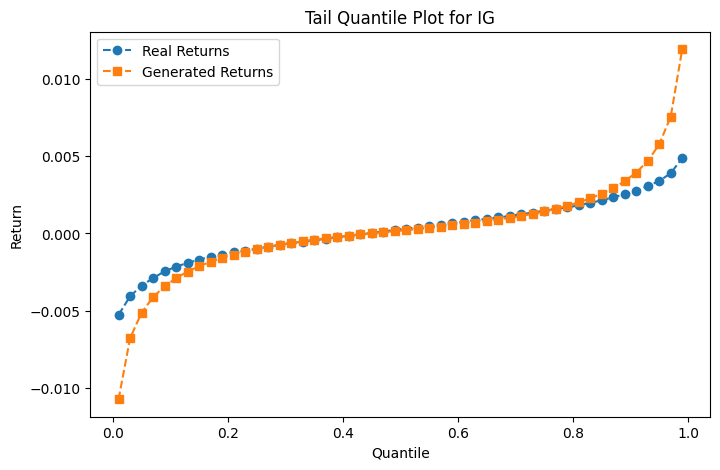


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 12.108539
Mean Distance: 0.006822
Median Distance: 0.000312
Standard Deviation: 0.114104


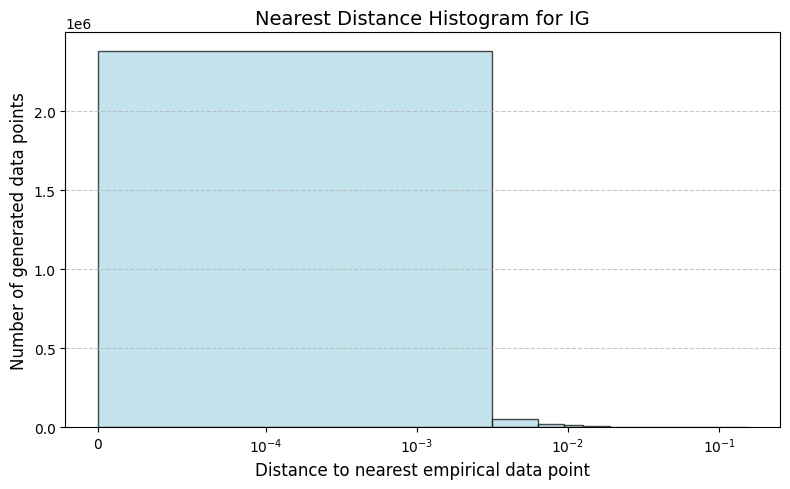


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000710


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Variance of Real Data: 0.000006
Variance of Generated Data: 0.000002
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.029836
✅ Generated samples are reasonably diverse


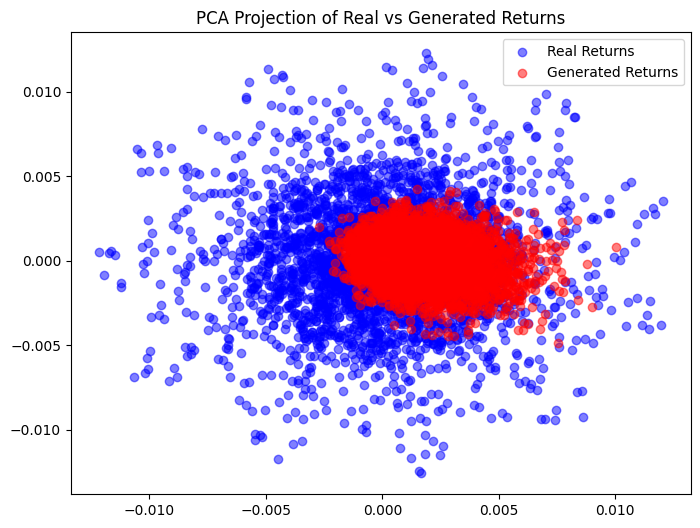

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt


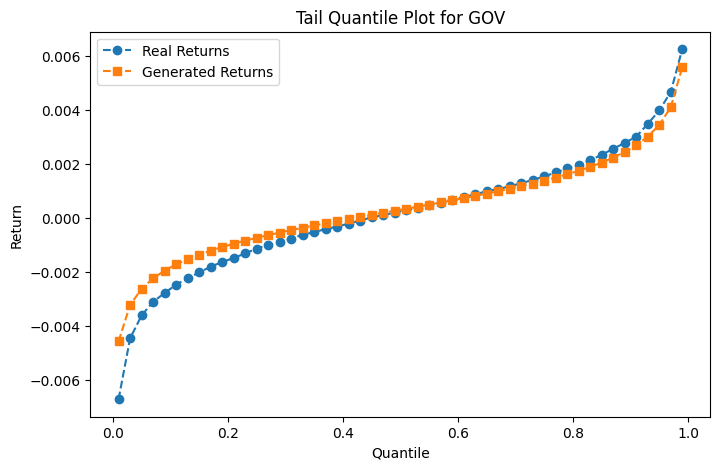


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt

📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 6.292504
Mean Distance: 0.001722
Median Distance: 0.000340
Standard Deviation: 0.017202


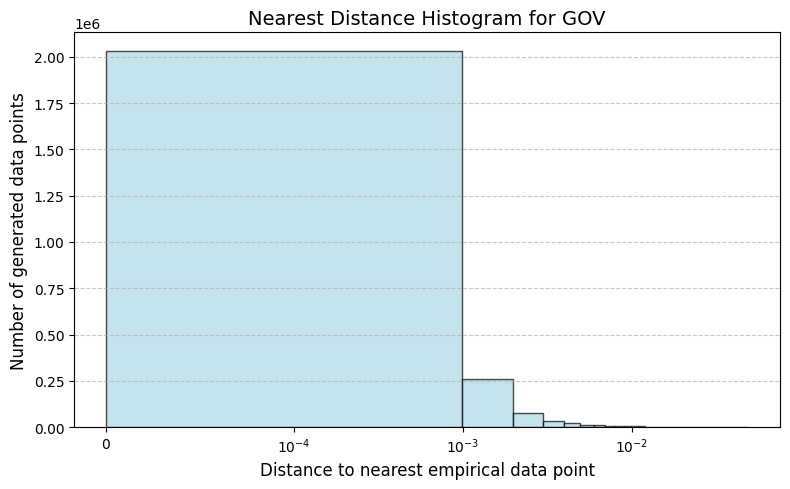


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
📊 Wasserstein Distance for GOV: 0.000387


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Variance of Real Data: 0.000009
Variance of Generated Data: 0.000200
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.172609
✅ Generated samples are reasonably diverse


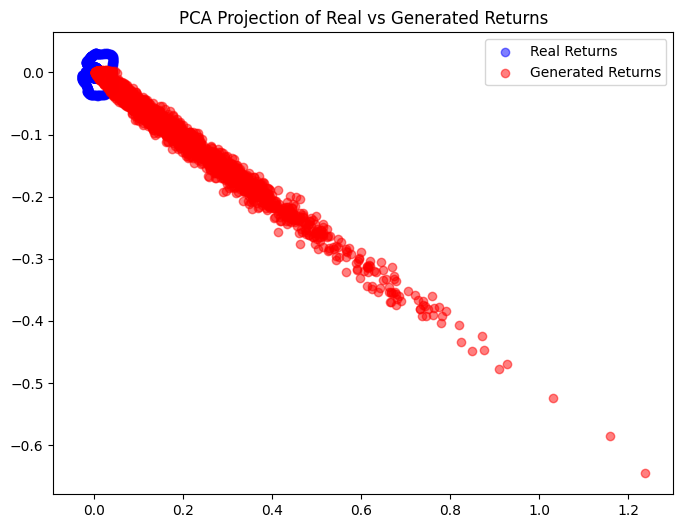

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt


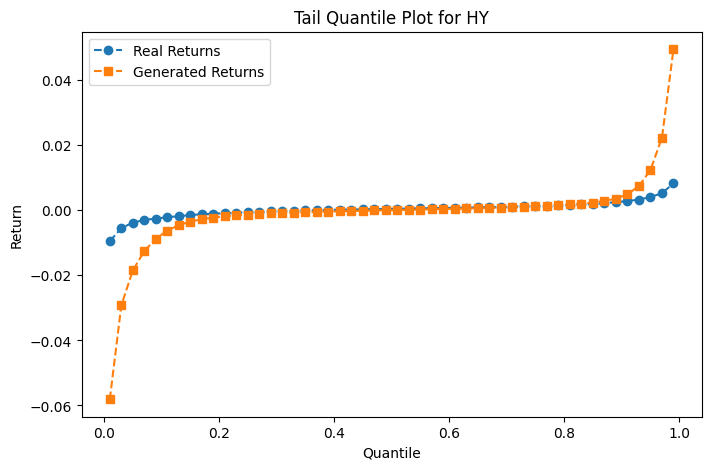


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt

📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 16.781787
Mean Distance: 0.005702
Median Distance: 0.000136
Standard Deviation: 0.099559


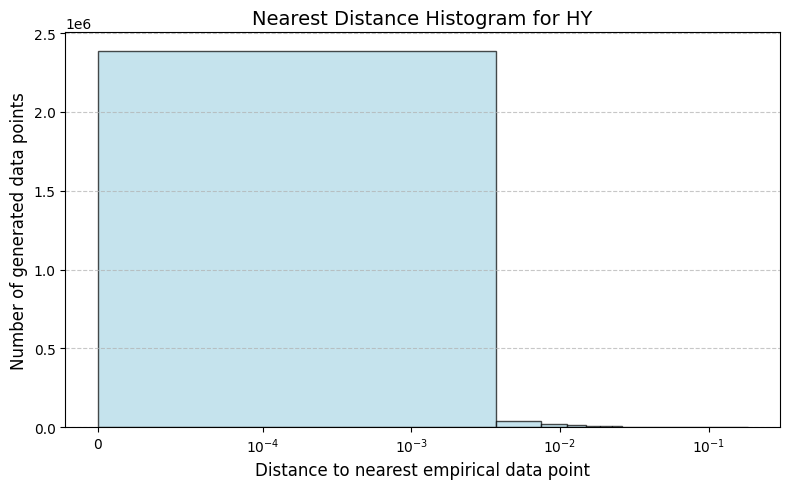


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
📊 Wasserstein Distance for HY: 0.004768


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.004111
✅ Generated samples are reasonably diverse


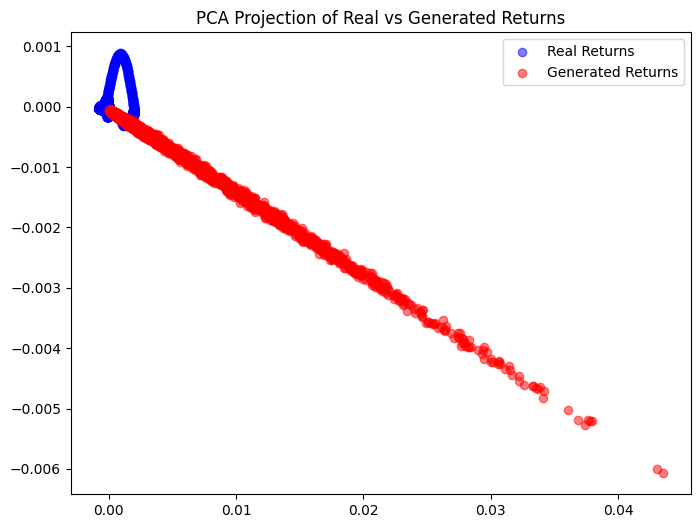


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000154



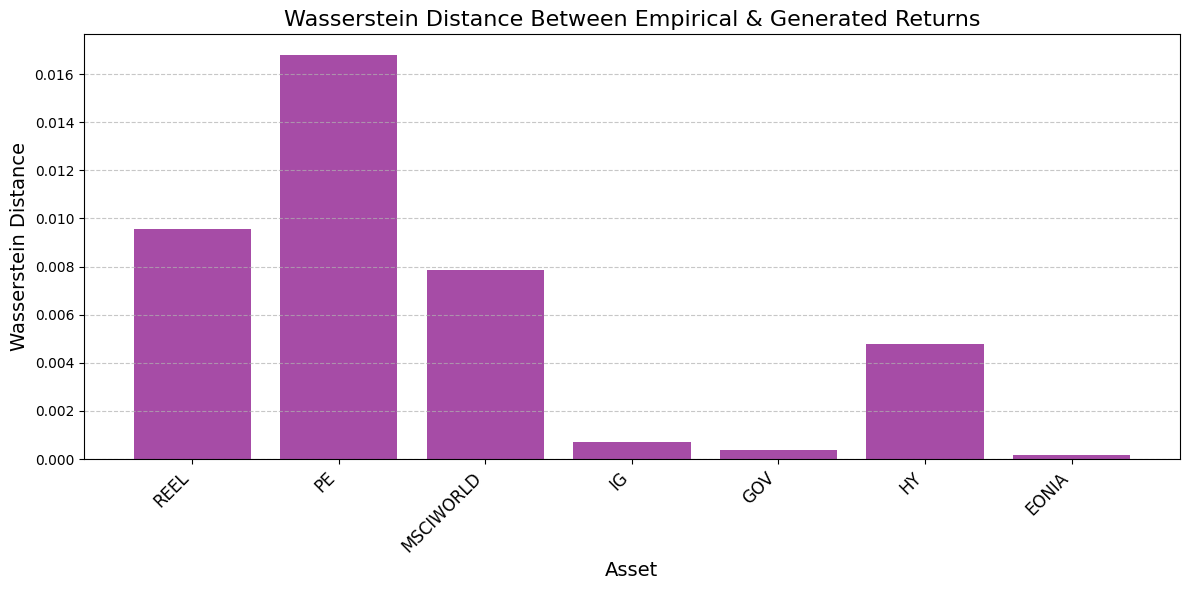

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'